In [ ]:
pip install langchain==0.2.11 langchain-community==0.2.10 scikit-learn==1.5.0 langchain-openai==0.1.22 langgraph==0.2.59 azure-search-documents azure-identity pyodbc pandas

In [2]:
import os
import re
from typing import TypedDict, List
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_openai import AzureOpenAIEmbeddings, AzureChatOpenAI
from langchain_community.vectorstores.azuresearch import AzureSearch
from langchain_community.utilities import SQLDatabase
from langgraph.graph import StateGraph


In [3]:
class State(TypedDict):
    question: str
    agent_rag: str
    agent_sql: str
    agent_csv: str
    answer: str

In [4]:
agents = ["agent_rag", "agent_sql", "agent_csv"]

## RAG agent

Retrieves relevant information from a predefined knowledge base and uses this context to generate accurate and contextually relevant responses.

![](images/agent_rag.png)

In [5]:
class AgentRag:
    
    def __init__(self, index, name="RAG Agent"): 
        self.name = name
        
        # Embeddings model instantiation
        self.embeddings = AzureOpenAIEmbeddings(model="ada-002", openai_api_version="2024-06-01")
        
        # Vector store instantiation
        self.vstore = AzureSearch(
            azure_search_endpoint=os.getenv("AZURE_SEARCH_URI"),
            azure_search_key=os.getenv("AZURE_SEARCH_KEY"),
            index_name=index,
            embedding_function=self.embeddings.embed_query
        )

        # LLM instantiation
        self.llm = AzureChatOpenAI(
            deployment_name="gpt-4o",
            api_version="2023-06-01-preview"
        )

        # The system prompt guides the agent on how to respond
        self.system_prompt = (
            "You are an AI assistant for question-answering tasks."
            "Use only the following pieces of retrieved context to answer the question." 
            "If you cannot find the answer in the context, say that you don't know." 
            "Use three sentences maximum and keep the answer concise."
            "\n\n"
            "Context: {context}"
        )

        # The prompt puts together the system prompt with the user question
        self.prompt = ChatPromptTemplate.from_messages(
            [
                ("system", self.system_prompt),
                ("human", "{question}"),
            ]
        )

        # The parser just plucks the string content out of the LLM's output message
        self.parser = StrOutputParser()

        # The chain orchestrates the whole flow
        self.rag_chain = (
            { "question": RunnableLambda(lambda inputs: inputs["question"]), "context": RunnableLambda(lambda inputs: inputs["context"]) }
            #| RunnableLambda(lambda inputs: (print(f"Logging Inputs: {inputs}") or inputs))
            | self.prompt
            | self.llm
            | self.parser
        )
       
    def retrieve_context(self, query):
        print(f"{self.name} says: retrieving relevant information...")      
        docs = self.vstore.similarity_search(query, k=3)
        print(f"{self.name} says: {docs}")
        # Put together the results of the similarity search into one chunk of text
        return "\n\n".join(doc.page_content for doc in docs)

    def generate_answer(self, state: State):
        print(f"{self.name} says: received question '{state['question']}'")

        # Retrieve the most relevant documents from the vector store
        context = self.retrieve_context(state['question'])

        print(f"{self.name} says: generating answer...")
        answer = self.rag_chain.invoke({"question": state["question"], "context": context})
        print(f"{self.name} says: {answer}")
        return { "agent_rag": answer }


In [6]:
agent_rag = AgentRag("rag-v2")

In [38]:
agent_rag.generate_answer({"question": "hablame acerca de los objetivos del proyecto de Fabian"})

RAG Agent says: received question 'hablame acerca de los objetivos del proyecto de Fabian'
RAG Agent says: retrieving relevant information...
RAG Agent says: [Document(metadata={'source': 'knowledge-base/charter.pdf', 'page': 3}, page_content='Plan de proyecto del Trabajo Final\nCarrera de Especializaci´ on en Inteligencia Artificial\nIng. Fabi´ an Alejandro Massotto\nActa de constituci´ on del proyecto\nBuenos Aires, 23 de abril de 2024\nPor medio de la presente se acuerda con el Ing. Fabi´ an Alejandro Massotto que su Trabajo\nFinal de la Carrera de Especializaci´ on en Inteligencia Artificial se titular´ a “Desarrollo de un\nchatbot especializado para optimizar la b´ usqueda de informaci´ on en documentos propietarios” y'), Document(metadata={'source': 'knowledge-base/charter.pdf', 'page': 5}, page_content='Plan de proyecto del Trabajo Final\nCarrera de Especializaci´ on en Inteligencia Artificial\nIng. Fabi´ an Alejandro Massotto\nLa propuesta de valor de este proyecto radica en su

{'agent_rag': 'El objetivo del proyecto de Fabián es desarrollar un chatbot especializado que pueda ser entrenado con documentos propietarios de una empresa. Este chatbot debe interpretar correctamente las consultas de los usuarios y proporcionar respuestas precisas y relevantes basadas en el contenido ingestado. Así, se busca optimizar la búsqueda de información, mejorando la eficiencia operativa de la empresa.'}

## SQL agent

An agent that can answer questions about a SQL database.

At a high level, the agent will: 

1. Fetch the available schema from the database (tables, columns and data types) 
2. Generate a query based on the question and information from the schema 
3. Double-check the query for common mistakes and adjust if needed
4. Execute the query
5. Formulate a response based on the results

![](images/agent_sql.png)

In [7]:
# Connection details for Azure SQL Server
server = "chatwithfabi-dev-sqlserver.database.windows.net"
database = "chatwithfabi-dev-sqldb"
username = os.getenv("SQL_AGENT_USERNAME")
password = os.getenv("SQL_AGENT_PASSWORD")
driver = "ODBC+Driver+18+for+SQL+Server"

# Construct the URI
db_uri = f"mssql+pyodbc://{username}:{password}@{server}:1433/{database}?driver={driver}"

In [8]:
class AgentSql:
    
    def __init__(self, db_uri, name="SQL Agent"): 
        self.name = name
        
        # Database instantiation
        self.db_uri = db_uri
        self.db = self.connect()
        
        # LLM instantiation
        self.llm = AzureChatOpenAI(
            deployment_name="gpt-4o",
            api_version="2023-06-01-preview"
        )

        # The prompt puts together the system prompt with the user question
        self.prompt = lambda inputs: ChatPromptTemplate.from_messages(
            [
                ("system", inputs["system_prompt"]),
                ("human", inputs["human_prompt"]),
            ]
        )

        # The parser just plucks the string content out of the LLM's output message
        self.parser = StrOutputParser()

        # A prompt to generate a SQL query from a user question
        self.query_generator_prompt = (
            "You are a SQL expert with a strong attention to detail."
            "Given an input question, output a syntactically correct SQL query to run."
            "Respond only with the generated query, nothing else."
            "When generating the query:"
            "- Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results." 
            "- You can order the results by a relevant column to return the most interesting examples in the database."
            "- Never query for all the columns from a specific table, only ask for the relevant columns given the question." 
            "- DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database."
            "- Pay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table."
            "\n\n"
            "Schema description (TABLE_SCHEMA, TABLE_NAME, COLUMN_NAME, DATA_TYPE): {schema}"
        )

        self.query_generator_chain = (
            { "question": RunnableLambda(lambda inputs: inputs["question"]), "schema": RunnableLambda(lambda inputs: inputs["schema"]) }
            #| RunnableLambda(lambda inputs: (print(f"Logging Inputs: {inputs}") or inputs))
            | RunnableLambda(lambda inputs: self.prompt({"system_prompt": self.query_generator_prompt, "human_prompt": inputs["question"]}))
            | self.llm
            | self.parser
        )

        # A prompt to double check the generated query and adjust if needed
        self.query_corrector_prompt = (
            "You are a SQL expert with a strong attention to detail."
            "Double check the SQL query for common mistakes, including:"
            "- Using NOT IN with NULL values"
            "- Using UNION when UNION ALL should have been used"
            "- Using BETWEEN for exclusive ranges"
            "- Data type mismatch in predicates"
            "- Properly quoting identifiers (e.g., using square brackets for column/table names)"
            "- Using the correct number of arguments for functions"
            "- Casting to the correct data type"
            "- Using the proper columns for joins"
            "- Ensuring TOP is used for limiting rows instead of LIMIT"
            "If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query."
            "Respond only with the rewritten query or the original query, nothing else."
        )

        self.query_corrector_chain = (
            { "query": RunnablePassthrough() }
            #| RunnableLambda(lambda inputs: (print(f"Logging Inputs: {inputs}") or inputs))
            | RunnableLambda(lambda inputs: self.prompt({"system_prompt": self.query_corrector_prompt, "human_prompt": inputs["query"]}))
            | self.llm
            | self.parser
        )

        # A prompt to generate an answer to the question given the information pulled from the database
        self.answer_generator_prompt = (
            "Given the following user question, corresponding SQL query, and SQL result, answer the user question."
            "\n\n"
            "SQL query: {query}"
            "SQL result: {result}"
        )

        self.answer_generator_chain = (
            { "question": RunnableLambda(lambda inputs: inputs["question"]), "query": RunnableLambda(lambda inputs: inputs["query"]), "result": RunnableLambda(lambda inputs: inputs["result"]) }
            #| RunnableLambda(lambda inputs: (print(f"Logging Inputs: {inputs}") or inputs))
            | RunnableLambda(lambda inputs: self.prompt({"system_prompt": self.answer_generator_prompt, "human_prompt": inputs["question"]}))
            | self.llm
            | self.parser
        )

    def connect(self):
        print(f"{self.name} says: connecting to database...")
        db = SQLDatabase.from_uri(self.db_uri)
        print(f"{self.name} says: connection established.")
        return db

    def check_connection(self):
        print(f"{self.name} says: checking connection to database...")
        try:
            self.db.run("""SELECT 1""")
            print(f"{self.name} says: connection up and running.")
            return True
        except Exception as e:
            print(f"{self.name} says: there is no open connection.")
            return False

    def get_schema(self):
        print(f"{self.name} says: retrieving database schema...")
        schema = self.db.run("""SELECT 
                                TABLE_SCHEMA, 
                                TABLE_NAME,
                                COLUMN_NAME,
                                DATA_TYPE 
                        FROM INFORMATION_SCHEMA.COLUMNS""")
        print(f"{self.name} says: {schema}")
        return schema

    def generate_query(self, question, schema):
        print(f"{self.name} says: generating query...")
        query = self.query_generator_chain.invoke({"question": question, "schema": schema})
        print(f"{self.name} says: {query}")

        print(f"{self.name} says: reviewing query...")
        corrected_query = self.query_corrector_chain.invoke(query)
        print(f"{self.name} says: {corrected_query}")

        cleaned_query = re.sub(r"^```sql\n", "", corrected_query)  # Remove start markdown
        cleaned_query = re.sub(r"\n```$", "", cleaned_query)  # Remove end markdown
        cleaned_query = re.sub(r"\n", " ", cleaned_query) # Replace new line with space
        cleaned_query = cleaned_query.strip() # Remove leading and trailing whitespace (just in case)
        
        return cleaned_query
    
    def run_query(self, query):
        print(f"{self.name} says: executing query...")
        result = self.db.run(query)
        print(f"{self.name} says: {result}")
        return result
    
    def generate_answer(self, state: State):
        print(f"{self.name} says: received question '{state['question']}'")
        
        # Reconnect with database if connection was closed
        if(self.check_connection() is False):
            self.connect()
        
        try:
            # Get tables and columns from the database
            schema = self.get_schema()

            # Construct a SQL query
            query = self.generate_query(state['question'], schema)

            # Execute the query
            result = self.run_query(query)

            # Finally answer the question
            print(f"{self.name} says: generating answer...")
            answer = self.answer_generator_chain.invoke({"question": state["question"], "query": query, "result": result})
            print(f"{self.name} says: {answer}")
            return { "agent_sql": answer }
        except Exception as e:
            print(f"{self.name} says: ERROR {e}")
            return { "agent_sql": f"I don't know" }

In [11]:
agent_sql = AgentSql(db_uri)

SQL Agent says: connecting to database...
SQL Agent says: connection established.


In [34]:
agent_sql.generate_answer({"question": "which are the 10 most expensive products?"})

SQL Agent says: received question 'which are the 10 most expensive products?'
SQL Agent says: checking connection to database...
SQL Agent says: connection up and running.
SQL Agent says: retrieving database schema...
SQL Agent says: [('sys', 'database_firewall_rules', 'id', 'int'), ('sys', 'database_firewall_rules', 'name', 'nvarchar'), ('sys', 'database_firewall_rules', 'start_ip_address', 'varchar'), ('sys', 'database_firewall_rules', 'end_ip_address', 'varchar'), ('sys', 'database_firewall_rules', 'create_date', 'datetime'), ('sys', 'database_firewall_rules', 'modify_date', 'datetime'), ('SalesLT', 'Customer', 'CustomerID', 'int'), ('SalesLT', 'Customer', 'NameStyle', 'bit'), ('SalesLT', 'Customer', 'Title', 'nvarchar'), ('SalesLT', 'Customer', 'FirstName', 'nvarchar'), ('SalesLT', 'Customer', 'MiddleName', 'nvarchar'), ('SalesLT', 'Customer', 'LastName', 'nvarchar'), ('SalesLT', 'Customer', 'Suffix', 'nvarchar'), ('SalesLT', 'Customer', 'CompanyName', 'nvarchar'), ('SalesLT', 'Cus

{'agent_sql': 'The 10 most expensive products are:\n\n1. Road-150 Red, 62 (List Price: $3578.27)\n2. Road-150 Red, 44 (List Price: $3578.27)\n3. Road-150 Red, 48 (List Price: $3578.27)\n4. Road-150 Red, 52 (List Price: $3578.27)\n5. Road-150 Red, 56 (List Price: $3578.27)\n6. Mountain-100 Silver, 38 (List Price: $3399.99)\n7. Mountain-100 Silver, 42 (List Price: $3399.99)\n8. Mountain-100 Silver, 44 (List Price: $3399.99)\n9. Mountain-100 Silver, 48 (List Price: $3399.99)\n10. Mountain-100 Black, 38 (List Price: $3374.99)'}

## CSV agent

An agent that can answer questions about CSV files.

At a high level, the agent will: 

1. Fetch an index file that contains a short summary of each csv file available (this file should be constructed manually and is mandatory for the agent to work) 
2. Select which files are relevant for the user question 
3. Get a small sample of each of the files
4. Generate Python code to interact with the data, based on the user question and the extract from the files
5. Execute the code
6. Formulate a response based on the results

![](images/agent_csv.png)

In [12]:
import pandas as pd
from pathlib import Path

In [13]:
class AgentCsv:
    
    def __init__(self, name="CSV Agent"): 
        self.name = name

        self.base_path = Path("C:\\Users\\Fabi\\Documents\\repos\\rag-ai-chatbot\\backend\\csv")
        self.index_path = self.base_path / "index.csv"
        
        # LLM instantiation
        self.llm = AzureChatOpenAI(
            deployment_name="gpt-4o",
            api_version="2023-06-01-preview"
        )

        # The prompt puts together the system prompt with the user question
        self.prompt = lambda inputs: ChatPromptTemplate.from_messages(
            [
                ("system", inputs["system_prompt"]),
                ("human", inputs["human_prompt"]),
            ]
        )

        # The parser just plucks the string content out of the LLM's output message
        self.parser = StrOutputParser()

        # A prompt to generate a SQL query from a user question
        self.file_selector_prompt = (
            "You are a file selector."
            "Given an input question and an index, provide a list with the most relevant files."
            "The list must be a comma separated string containing only the file names."
            "Respond only with the generated list, nothing else."
            "\n\n"
            "Index: {index}"
        )

        self.file_selector_chain = (
            { "question": RunnableLambda(lambda inputs: inputs["question"]), "index": RunnableLambda(lambda inputs: inputs["index"]) }
            #| RunnableLambda(lambda inputs: (print(f"Logging Inputs: {inputs}") or inputs))
            | RunnableLambda(lambda inputs: self.prompt({"system_prompt": self.file_selector_prompt, "human_prompt": inputs["question"]}))
            | self.llm
            | self.parser
        )

        # A prompt to double check the generated query and adjust if needed
        self.code_generator_prompt = (
            "You are a Python expert specialized in working with CSV files using the pandas library."
            "Given an input question, output a syntactically correct Python code to run."
            "Respond only with the generated code, nothing else."
            "When generating the code:"
            "- Understand the context: analyze the user's question and the CSV data provided to infer the structure and relevant fields." 
            "- Use pandas library to load, manipulate, and analyze the data."
            "- Avoid unnecessary dependencies, use only pandas and Python's standard libraries."
            "- Handle edge cases such as missing values or empty datasets gracefully." 
            "- Ensure the code is executable."
            "- ALWAYS assign the final result to a variable called 'result'"
            "- DO NOT attempt to modify the data in the csv files."
            f"- Have into account that the csv files are located in the following path: {self.base_path}"
            "\n\n"
            "Context: {context}"
        )

        self.code_generator_chain = (
            { "question": RunnableLambda(lambda inputs: inputs["question"]), "context": RunnableLambda(lambda inputs: inputs["context"]) }
            #| RunnableLambda(lambda inputs: (print(f"Logging Inputs: {inputs}") or inputs))
            | RunnableLambda(lambda inputs: self.prompt({"system_prompt": self.code_generator_prompt, "human_prompt": inputs["question"]}))
            | self.llm
            | self.parser
        )

        # A prompt to generate an answer to the question given the information pulled from the database
        self.answer_generator_prompt = (
            "Given the following user question, corresponding Python code, and the result of executing the code, answer the user question."
            "\n\n"
            "Python code: {code}"
            "Python result: {result}"
        )

        self.answer_generator_chain = (
            { "question": RunnableLambda(lambda inputs: inputs["question"]), "code": RunnableLambda(lambda inputs: inputs["code"]), "result": RunnableLambda(lambda inputs: inputs["result"]) }
            #| RunnableLambda(lambda inputs: (print(f"Logging Inputs: {inputs}") or inputs))
            | RunnableLambda(lambda inputs: self.prompt({"system_prompt": self.answer_generator_prompt, "human_prompt": inputs["question"]}))
            | self.llm
            | self.parser
        )

    def get_index(self):
        print(f"{self.name} says: retrieving index file...")
        index = pd.read_csv(self.index_path)
        print(f"{self.name} says:\n {index}")
        return index

    def get_relevant_files(self, question, index):
        print(f"{self.name} says: getting relevant files...")
        files = self.file_selector_chain.invoke({"question": question, "index": index})
        if files == "":
            files_list = []
        else:
            files_list = files.replace(" ", "").split(",")
        print(f"{self.name} says: {files_list}")
        return files_list
    
    def get_files_head(self, files_list):
        print(f"{self.name} says: getting a sample from the files...")
        files_head = {}
        for file in files_list:
            head = pd.read_csv(self.base_path / file, nrows=5)
            print(f"{self.name} says:\n {head}")
            files_head[file] = head.fillna("null").to_dict(orient="records")
        return files_head

    def generate_code(self, question, context):
        print(f"{self.name} says: generating code...")
        code = self.code_generator_chain.invoke({"question": question, "context": context})
        print(f"{self.name} says: {code}")
        
        cleaned_code = re.sub(r"^```python\n", "", code)  # Remove start markdown
        cleaned_code = re.sub(r"\n```$", "", cleaned_code)  # Remove end markdown
        return cleaned_code
    
    def run_code(self, code):
        safe_globals = {}
        safe_locals = {}
        print(f"{self.name} says: executing code...")
        exec(code, safe_globals, safe_locals)
        print(f"{self.name} says: {safe_locals['result']}")
        return safe_locals['result']
    
    def generate_answer(self, state: State):
        print(f"{self.name} says: received question '{state['question']}'")
        
        try:
            # Get index file
            index = self.get_index()

            # Get relevant files
            relevant_files = self.get_relevant_files(state['question'], index)
            
            # Get an extract from the relevant files
            context = self.get_files_head(relevant_files)

            # Generate Python code to interact with the files
            code = self.generate_code(state['question'], context)

            # Execute the code
            result = self.run_code(code)

            # Finally answer the question
            print(f"{self.name} says: generating answer...")
            answer = self.answer_generator_chain.invoke({"question": state["question"], "code": code, "result": result})
            print(f"{self.name} says: {answer}")
            return { "agent_csv": answer }
        except Exception as e:
            print(f"{self.name} says: ERROR {e}")
            return { "agent_csv": f"I don't know" }

In [14]:
agent_csv = AgentCsv()

In [156]:
agent_csv.generate_answer({"question": "any superhero called Fabian?"})

CSV Agent says: received question 'any superhero called Fabian?'
CSV Agent says: retrieving index file...
CSV Agent says:
     FILE_NAME                                            SUMMARY
0      dc.csv  contains details about DC superheroes, like Su...
1  marvel.csv  contains details about Marvel superheroes, lik...
CSV Agent says: getting relevant files...
CSV Agent says: ['dc.csv', 'marvel.csv']
CSV Agent says: getting a sample from the files...
CSV Agent says:
    Id                        Name Identity Alignment   Eyes   Hair     Sex  \
0   2                 John Malone   Secret       Bad   Blue  White    Male   
1   3         Samuel Bradley, Jr.   Public       Bad  Brown  Brown    Male   
2   4                   Hope Taya   Public       Bad  Brown  Black  Female   
3   5                       Trygg   Secret       Bad  Black  Black    Male   
4   6  Boris Dmitravich Razumihin   Public      Good  Brown  Black    Male   

  Alive  Appearances  First_appeared     Planet Universe  
0  

{'agent_csv': 'Yes, there are superheroes (or characters) called Fabian. Here are the details:\n\n1. **Fabian LaMuerto**\n   - Identity: Public\n   - Alignment: Bad\n   - Eyes: Black\n   - Hair: Black\n   - Sex: Male\n   - Alive: Yes\n   - Appearances: 2\n   - First appeared: July 1998\n   - Planet: Earth-616\n   - Universe: Marvel\n\n2. **Fabian Stankowicz**\n   - Identity: Public\n   - Alignment: Good\n   - Eyes: Blue\n   - Hair: Grey\n   - Sex: Male\n   - Alive: Yes\n   - Appearances: 52\n   - First appeared: March 1982\n   - Planet: Earth-616\n   - Universe: Marvel\n\n3. **Fabian Marechal-Julbin**\n   - Identity: Secret\n   - Alignment: Bad\n   - Eyes: Blue\n   - Hair: Brown\n   - Sex: Male\n   - Alive: No\n   - Appearances: 16\n   - First appeared: March 1991\n   - Planet: Earth-616\n   - Universe: Marvel\n\n4. **Fabian Cortez**\n   - Identity: Public\n   - Alignment: Bad\n   - Eyes: Blue\n   - Hair: Brown\n   - Sex: Male\n   - Alive: No\n   - Appearances: 49\n   - First appeared:

## Supervisor

Picks the next agent to process and decides when the work is completed. Then generates a final answer based on the output of the other agents.

In [15]:
class Supervisor:
    
    def __init__(self, agent_list): 

        # List with all the agents to supervise
        self.agents = agent_list

        # Instantiate a pre-trained Large Language Model from Azure OpenAI
        self.llm = AzureChatOpenAI(
            deployment_name="gpt-4o",
            api_version="2023-06-01-preview"
        )

        # The system prompt guides the agent on how to respond
        self.system_prompt = (
            f"You are a supervisor tasked with managing a conversation between the following workers: {self.agents}."
            "Given the following user question, all the workers will provide a response."
            "Your task is to analyze each of the responses and provide the best possible response to the user."
            "Do not make up for new information that is not explicitly in the workers response."
            "\n\n"
            "Workers response: {agents_output}"
        )

        # The prompt puts together the system prompt with the user question
        self.prompt = ChatPromptTemplate.from_messages(
            [
                ("system", self.system_prompt),
                ("human", "{question}"),
            ]
        )

        # The parser just plucks the string content out of the LLM's output message
        self.parser = StrOutputParser()

        # The chain orchestrates the whole flow
        self.rag_chain = (
            {"question": RunnableLambda(lambda inputs: inputs["question"]), "agents_output": RunnableLambda(lambda inputs: inputs["agents_output"]), "history": RunnableLambda(lambda inputs: inputs["history"])}
            #| RunnableLambda(lambda inputs: (print(f"Logging Inputs: {inputs}") or inputs))
            | self.prompt
            | self.llm
            | self.parser
        )
       
    def pick_next_agent(self, state: State):
        for agent in self.agents:
            if agent not in state:
                print(f"Next agent: {agent}")
                return { "next": agent }
        return { "next": "FINISH" }

    def summarize(self, state: State):
        print("Summarizing...")
        agents_output = {key: state[key] for key in self.agents if key in state}
        answer = self.rag_chain.invoke({"question": state["question"], "agents_output": agents_output, "history": []})
        return { "answer": answer }


In [16]:
supervisor = Supervisor(agents)

In [12]:
supervisor.pick_next_agent({"question": "hablame acerca de los objetivos del proyecto de Fabian"})

Next agent: agent_rag


{'next': 'agent_rag'}

In [11]:
supervisor.pick_next_agent({"question": "hablame acerca de los objetivos del proyecto de Fabian", "agent_rag": "El objetivo del proyecto de Fabián es desarrollar un chatbot"})

Next agent: agent_sql


{'next': 'agent_sql'}

In [13]:
supervisor.summarize({"question": "hablame acerca de los objetivos del proyecto de Fabian", "agent_rag": "El objetivo del proyecto de Fabián es desarrollar un chatbot"})

Summarizing...


{'answer': 'El objetivo del proyecto de Fabián es desarrollar un chatbot.'}

## Graph

In [17]:
builder = StateGraph(State)

builder.add_node("supervisor_node", supervisor.pick_next_agent)
builder.add_node("summarizer_node", supervisor.summarize)
builder.add_node("rag_node", agent_rag.generate_answer)
builder.add_node("sql_node", agent_sql.generate_answer)
builder.add_node("csv_node", agent_csv.generate_answer)

builder.add_conditional_edges(
    "supervisor_node",
    RunnableLambda(lambda inputs: inputs["next"]),  
    {"agent_rag": "rag_node", "agent_sql": "sql_node", "agent_csv": "csv_node", "FINISH": "summarizer_node"}
)
builder.add_edge("rag_node", "supervisor_node")
builder.add_edge("sql_node", "supervisor_node")
builder.add_edge("csv_node", "supervisor_node")

builder.set_entry_point("supervisor_node")

graph = builder.compile()

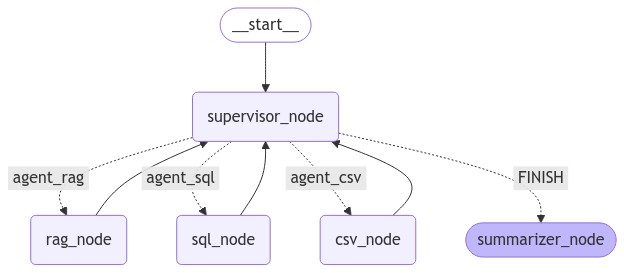

In [18]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
graph.invoke({"question": "quien es Fabian?"})

Next agent: agent_rag
RAG Agent says: received question 'quien es Fabian?'
RAG Agent says: retrieving relevant information...
RAG Agent says: [Document(metadata={'source': 'knowledge-base/charter.pdf', 'page': 3}, page_content='Plan de proyecto del Trabajo Final\nCarrera de Especializaci´ on en Inteligencia Artificial\nIng. Fabi´ an Alejandro Massotto\nActa de constituci´ on del proyecto\nBuenos Aires, 23 de abril de 2024\nPor medio de la presente se acuerda con el Ing. Fabi´ an Alejandro Massotto que su Trabajo\nFinal de la Carrera de Especializaci´ on en Inteligencia Artificial se titular´ a “Desarrollo de un\nchatbot especializado para optimizar la b´ usqueda de informaci´ on en documentos propietarios” y'), Document(metadata={'source': 'knowledge-base/charter.pdf', 'page': 5}, page_content='Cliente: conoce los requerimientos del problema inicial.\nResponsable: encargado de llevar a cabo el desarrollo del proyecto.\nOrientador: referente en las cuestiones t´ ecnicas y organizativas 

{'question': 'quien es Fabian?',
 'agent_rag': 'Fabián Alejandro Massotto es un ingeniero que está desarrollando su Trabajo Final de la Carrera de Especialización en Inteligencia Artificial, titulado "Desarrollo de un chatbot especializado para optimizar la búsqueda de información en documentos propietarios".',
 'agent_sql': 'La consulta SQL busca clientes con el nombre de "Fabian" en la tabla "SalesLT.Customer". Sin embargo, el resultado de la consulta no ha sido proporcionado en tu pregunta. Si la consulta devolvió resultados, mostrará los primeros cinco registros con el nombre de "Fabian" junto con sus apellidos.\n\nSi hubiera resultados, la respuesta sería algo así como:\n\n"Los clientes con el nombre \'Fabian\' son:\n1. Fabian [Apellido1]\n2. Fabian [Apellido2]\n...\n\nDado que no tengo los datos específicos del resultado, no puedo proporcionar los detalles exactos de quiénes son los clientes llamados \'Fabian\'."',
 'agent_csv': 'En el universo de los cómics de Marvel, hay varios

In [21]:
graph.invoke({"question": "cuales son los 10 productos mas vendidos?"})

Next agent: agent_rag
RAG Agent says: received question 'cuales son los 10 productos mas vendidos?'
RAG Agent says: retrieving relevant information...
RAG Agent says: [Document(metadata={'source': 'knowledge-base/charter.pdf', 'page': 13}, page_content='Descripci´ on Cantidad Valor unitario Valor total\nCalculados como el 40 % de los costos directos 1 $4.856.000 $4.856.000\nSUBTOTAL $4.856.000\nTOTAL $16.996.000\n13. Gesti´ on de riesgos\na) Identificaci´ on de los riesgos y estimaci´ on de sus consecuencias. Se utiliza una escala de 1 a\n10 para estimar la severidad y la probabilidad de ocurrencia.\nRiesgo 1: el chatbot no logra entender adecuadamente las consultas de los usuarios.\nSeveridad (S): 9.'), Document(metadata={'source': 'knowledge-base/charter.pdf', 'page': 1}, page_content='6. Requerimientos . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 7\n7. Historias de usuarios ( Product backlog ). . . . . . . . . . . . . . . . . . . . . . . 8\n8. Entregable

{'question': 'cuales son los 10 productos mas vendidos?',
 'agent_rag': 'Lo siento, pero no tengo información sobre los 10 productos más vendidos en el contexto proporcionado.',
 'agent_sql': 'Los 10 productos más vendidos son:\n\n1. Classic Vest, S (87 unidades vendidas)\n2. Short-Sleeve Classic Jersey, XL (57 unidades vendidas)\n3. Bike Wash - Dissolver (55 unidades vendidas)\n4. Water Bottle - 30 oz. (54 unidades vendidas)\n5. AWC Logo Cap (52 unidades vendidas)\n6. Long-Sleeve Logo Jersey, L (51 unidades vendidas)\n7. Racing Socks, L (51 unidades vendidas)\n8. Short-Sleeve Classic Jersey, L (51 unidades vendidas)\n9. Sport-100 Helmet, Black (51 unidades vendidas)\n10. Hydration Pack - 70 oz. (50 unidades vendidas)',
 'agent_csv': "I don't know",
 'answer': 'Los 10 productos más vendidos son:\n\n1. Classic Vest, S (87 unidades vendidas)\n2. Short-Sleeve Classic Jersey, XL (57 unidades vendidas)\n3. Bike Wash - Dissolver (55 unidades vendidas)\n4. Water Bottle - 30 oz. (54 unidades v

In [23]:
graph.invoke({"question": "cuando fue la primera aparicion de Spiderman?"})

Next agent: agent_rag
RAG Agent says: received question 'cuando fue la primera aparicion de Spiderman?'
RAG Agent says: retrieving relevant information...
RAG Agent says: [Document(metadata={'source': 'knowledge-base/charter.pdf', 'page': 3}, page_content='consistir´ a en la implementaci´ on de un modelo de inteligencia artificial que interprete consultas de\nusuarios y proporcione respuestas precisas y relevantes basadas en el contenido de documentos\nde car´ acter muy espec´ ıfico. El trabajo tendr´ a un presupuesto preliminar estimado de 607 horas\ny un costo estimado de $16.996.000, con fecha de inicio el 23 de abril de 2024 y fecha de\npresentaci´ on p´ ublica el 10 de abril de 2025.\nSe adjunta a esta acta la planificaci´ on inicial.'), Document(metadata={'source': 'knowledge-base/charter.pdf', 'page': 7}, page_content='o estructuras espec´ ıficas. Story points : 13 (complejidad: 3, dificultad: 5, incertidumbre: 3)\nP´ agina 8 de 18'), Document(metadata={'source': 'knowledge-base

{'question': 'cuando fue la primera aparicion de Spiderman?',
 'agent_rag': 'No sé cuándo fue la primera aparición de Spiderman.',
 'agent_sql': 'No se encontró ninguna entrada en el registro de errores que contenga "Spiderman". Podrías verificar si el término está escrito correctamente o proporcionar más detalles para refinar la búsqueda.',
 'agent_csv': 'La primera aparición de Spiderman fue en diciembre de 1946.',
 'answer': 'La primera aparición de Spiderman fue en diciembre de 1946.'}